# **Transformer**

---

## **Introduction**

Transformer is a powerful neural network architecture based entirely on attention mechanisms, originally proposed for Natural Language Processing. Unlike RNNs, it does not rely on recurrence and processes sequences in parallel, which makes it especially attractive for long-range dependencies, including EEG signals in Brain-Computer Interface (BCI) applications.

**Core ideas of Transformer:**
- Self-Attention Mechanism  
- Positional Encoding  
- Parallel Sequence Modeling  

---

## **Basic Structure**

Transformer uses an **encoder-decoder** architecture, but in many applications (including EEG regression/classification), only the encoder is used.

### (1) Input Embedding + Positional Encoding

Each input vector $x_t$ is first embedded and then augmented with positional encoding to retain temporal order:

$$
z_t = x_t W_E + PE_t
$$

Where:
- $W_E$: embedding matrix (or identity if input is already dense)
- $PE_t$: positional encoding for position $t$

---

### (2) Scaled Dot-Product Attention

The core of Transformer is the attention mechanism. Given query $Q$, key $K$, and value $V$ matrices:

$$
\text{Attention}(Q, K, V) = \text{softmax}\left( \frac{QK^\top}{\sqrt{d_k}} \right)V
$$

This allows the model to weigh different time points in the input sequence based on their relevance.

---

### (3) Multi-Head Attention

To capture information from multiple subspaces, multi-head attention is used:

$$
\text{MultiHead}(Q, K, V) = \text{Concat}(head_1, ..., head_h)W^O
$$

Each head computes its own attention with separate projections.

---

### (4) Feedforward and Layer Norm

Each attention block is followed by a position-wise feedforward network:

$$
\text{FFN}(x) = \text{ReLU}(xW_1 + b_1)W_2 + b_2
$$

Transformer applies **residual connections** and **layer normalization** after each block.

---


## **Typical Transformer Encoder**

Input Sequence (e.g., EEG 63×200)  
→ Linear Projection (optional)  
→ Add Positional Encoding  
→ Multi-Head Self-Attention  
→ Feedforward Network  
→ Output (e.g., Regression head or Classifier)

---

## **Advantages of Transformer**

| Advantages | Description |
|------------|-------------|
| Captures Long-Term Dependencies | Global self-attention spans the entire sequence |
| Fast Training | Fully parallel computation |
| Strong Performance | Outperforms RNNs in many tasks |
| Flexible Input | Works with various sequence lengths and dimensions |

---

## **Application Scenarios**

Transformers are widely used in:

- Natural Language Processing  
- Time-Series Forecasting  
- EEG Signal Decoding  
- Brain State Classification  
- Multimodal Fusion  

---

## **Transformer in BCI**

### Typical Use Cases:
- EEG-based emotion or intent decoding  
- Long-range EEG sequence modeling  
- Multichannel EEG attention mechanisms  
- Interpretable BCI via attention weights  

### Advantages in BCI:
- Learns global interactions across EEG channels and time  
- Does not rely on fixed electrode layout or order  
- Can highlight important time points or regions via attention  
- Scales well to high-density EEG or multimodal data  

---

## **Prerequisites**

- `numpy`  
- `torch`  
- `matplotlib`  
- `scikit-learn`  
- `einops` (optional for attention reshaping)

---

In practice, Transformer models often benefit from pretraining, data augmentation, and efficient attention variants for long EEG sequences.


In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

from sklearn.metrics import mean_squared_error

from utils import (
    load_data_model,
)

# load train and test data
data_dir = "../data/data_model/sub-jimingda/forward1.npz"
data_list = load_data_model(data_dir)
train_data, train_label = data_list["feature_train"], data_list["steering_train"]
test_data, test_label = data_list["feature_test"], data_list["steering_test"]

In [2]:
# DataLoader
train_dataset = TensorDataset(torch.tensor(train_data, dtype=torch.float32),
                              torch.tensor(train_label, dtype=torch.float32))
test_dataset = TensorDataset(torch.tensor(test_data, dtype=torch.float32),
                             torch.tensor(test_label, dtype=torch.float32))
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

In [4]:
class EEG_Transformer(nn.Module):
    def __init__(self, input_dim=63, seq_len=200, d_model=128, nhead=4, num_layers=3, dropout=0.1):
        super(EEG_Transformer, self).__init__()

        self.input_proj = nn.Linear(input_dim, d_model)

        self.pos_embedding = nn.Parameter(torch.randn(1, seq_len, d_model))

        encoder_layer = nn.TransformerEncoderLayer(d_model=d_model, nhead=nhead, dropout=dropout, batch_first=True)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)

        self.regressor = nn.Sequential(
            nn.Linear(d_model, 64),
            nn.ReLU(),
            nn.Linear(64, 1)
        )

    def forward(self, x):
        # x shape: (B, 63, 200) → (B, 200, 63)
        x = x.permute(0, 2, 1)

        x = self.input_proj(x) + self.pos_embedding 
        x = self.transformer_encoder(x)              

        x = x.mean(dim=1)  # 均值池化，也可换成 x[:, 0, :] 使用第一个 token
        out = self.regressor(x)

        return out.squeeze(1)

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = EEG_Transformer().to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

In [6]:
num_epochs = 10
train_loss_list = []

for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0

    for inputs, targets in train_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item() * inputs.size(0)

    epoch_loss /= len(train_loader)
    train_loss_list.append(epoch_loss)
    # print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {epoch_loss:.4f}")

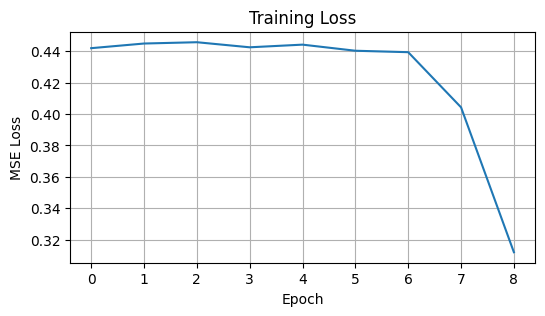

In [7]:
plt.figure(figsize=(6, 3))
plt.plot(train_loss_list[1:])
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.title('Training Loss')
plt.grid()
plt.show()

In [8]:
model.eval()
predictions, targets_all = [], []
with torch.no_grad():
    for inputs, targets in test_loader:
        inputs = inputs.to(device)
        outputs = model(inputs).cpu().numpy()
        predictions.extend(outputs)
        targets_all.extend(targets.numpy())

mse = mean_squared_error(targets_all, predictions)
print(f"Test MSE: {mse:.4f}")

Test MSE: 0.0037


In [12]:
# plt.figure(figsize=(10, 4))
# plt.plot(predictions[:1000], label="Predicted")
# plt.plot(targets_all[:1000], label="True", alpha=0.7)
# plt.legend()
# plt.title("LSTM Prediction")
# plt.xlabel("Sample")
# plt.ylabel("Steering Angle")
# plt.tight_layout()
# plt.show()